In [1]:
from helper import *
import logging
from albumentations.pytorch import ToTensorV2
# from multiprocessing import Pool, set_start_method
import albumentations as A
import timm
from datetime import datetime
from itertools import cycle
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
# from torch.utils.tensorboard import SummaryWriter
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import matthews_corrcoef, accuracy_score
import os
import numpy as np
import pandas as pd
import random
import cv2
from math import ceil
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
CFG = {
    'seed': 42,
    'test_size': 1000,
    'lr': 1,
    'use_multi': False,
    'num_workers': 8,
    'batch_size': 64,
    'iterations': 1,
    'val_wait': 1,
    'scheduler_patience': 100,
    'saver_mode': 'all',
    'es_patience': 2,
    'rop_factor': 0.5,
    'rop_patience': 100,
}


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])

In [4]:
%%time
df = pd.read_csv('./final_data2.csv')
df['bbox_endzone'] = df['bbox_endzone'].apply(process_bbox)
df['bbox_sideline'] = df['bbox_sideline'].apply(process_bbox)

CPU times: user 52.5 s, sys: 877 ms, total: 53.4 s
Wall time: 53.5 s


In [5]:
categorical_data_for_fitting = [
    ['home', 'CB', 'home', 'CB', ] ,
    ['home', 'DE', 'home', 'DE', ],
    ['home', 'FS', 'home', 'FS', ],
    ['home', 'TE', 'home', 'TE', ] ,
    ['home', 'ILB', 'home', 'ILB', ],
    ['home', 'OLB', 'home', 'OLB', ],
    ['home', 'T', 'home', 'T', ],
    ['home', 'G', 'home', 'G', ] ,
    ['home', 'C', 'home', 'C', ] ,
    ['home', 'QB', 'home', 'QB', ],
    ['home', 'WR', 'home', 'WR', ],
    ['home', 'RB', 'home', 'RB', ],
    ['home', 'NT', 'home', 'NT', ],
    ['home', 'DT', 'home', 'DT', ],
    ['home', 'MLB', 'home', 'MLB', ],
    ['home', 'SS', 'home', 'SS', ] ,
    ['home', 'OT', 'home', 'OT', ],
    ['home', 'LB', 'home', 'LB', ],
    ['home', 'OG', 'home', 'OG', ] ,
    ['home', 'SAF', 'home', 'SAF', ],
    ['home', 'DB', 'home', 'DB', ] ,
    ['home', 'LS', 'home', 'LS', ] ,
    ['home', 'K', 'home', 'K', ],
    ['home', 'P', 'home', 'P', ],
    ['home', 'FB', 'home', 'FB', ] ,
    ['home', 'S', 'home', 'S', ],
    ['home', 'DL', 'Ground', 'DL', ],
    ['away', 'HB', 'away', 'HB', ],
    ['away', 'HB', 'away', 'Ground', ],
]
    
one_hot = OneHotEncoder()
one_hot.fit(categorical_data_for_fitting)

OneHotEncoder()

In [6]:
one_hot.transform(categorical_data_for_fitting).toarray()

a = np.array(categorical_data_for_fitting)
a.shape

(29, 4)

In [7]:
df_G1 = df.loc[(df['contact'] == 1) & (df['G_flug'] == True)]
df_G0 = df.loc[(df['contact'] == 0) & (df['G_flug'] == True)]
df_P1 = df.loc[(df['contact'] == 1) & (df['G_flug'] == False)]
df_P0 = df.loc[(df['contact'] == 0) & (df['G_flug'] == False)]


In [8]:
random_state = 42

train_G1, test_G1 = train_test_split(
    df_G1, test_size=CFG['test_size']//4, random_state=random_state)
train_G0, test_G0 = train_test_split(
    df_G0, test_size=CFG['test_size']//4, random_state=random_state)
train_P1, test_P1 = train_test_split(
    df_P1, test_size=CFG['test_size']//4, random_state=random_state)
train_P0, test_P0 = train_test_split(
    df_P0, test_size=CFG['test_size']//4, random_state=random_state)


In [11]:
valid_aug = A.Compose([
        A.Normalize(mean=[0.], std=[1.]),
        ToTensorV2()
    ])

In [13]:
test_df = pd.concat([test_G1, test_P1, test_P0, test_G0]).reset_index()

In [72]:
class MyDataset(Dataset):
    def __init__(self, df, aug, one_hot_transform, feature_cols=['rel_pos_x',
                                                                 'rel_pos_y', 'rel_pos_mag', 'rel_pos_ori', 'rel_speed_x', 'rel_speed_y',
                                                                 'rel_speed_mag', 'rel_speed_ori', 'rel_acceleration_x',
                                                                 'rel_acceleration_y', 'rel_acceleration_mag', 'rel_acceleration_ori',
                                                                 'G_flug', 'orientation_1', 'orientation_2']):

        self.df = df
        self.features = feature_cols
        self.aug = aug
        self.one_hot_transform = one_hot_transform

    def __len__(self):
        return len(self.df)

    def normalize_features(self, features):
        """
        normalizes the features of the players

       'rel_pos_x',
       'rel_pos_y', 'rel_pos_mag', 'rel_pos_ori', 'rel_speed_x', 'rel_speed_y',
       'rel_speed_mag', 'rel_speed_ori', 'rel_acceleration_x',
       'rel_acceleration_y', 'rel_acceleration_mag', 'rel_acceleration_ori',
       'G_flug', 'orientation_1', 'orientation_2'
        """
        features /= 100
        features[3] /= 3.6
        features[7] /= 3.6
        features[11] /= 3.6
        features[13] /= 3.6
        features[14] /= 3.6
        return features

    def __getitem__(self, idx):
        window = 24
        frames_to_skip = 4

        row = self.df.iloc[idx]
        mid_frame = row['frame']

        label = float(row['contact'])
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = row['game_play'] + f'_{view}.mp4'
            frames = [mid_frame - window +
                      i for i in range(0, 2*window+1, frames_to_skip)]

            bbox_col = 'bbox_endzone' if view == 'Endzone' else 'bbox_sideline'
            bboxes = row[bbox_col][::frames_to_skip].astype(np.int32)

            if bboxes.sum() <= 0:
                imgs += [np.zeros((256, 256), dtype=np.float32)]*len(frames)
                continue

            for i, frame in enumerate(frames):
                img_new = np.zeros((256, 256), dtype=np.float32)
                cx, cy = bboxes[i]
                path = f'./work/train_frames/{video}_{frame:04d}.jpg'
                if os.path.isfile(path):
                    img_new = np.zeros((256, 256), dtype=np.float32)
                    if view == 'Endzone':
                        img = cv2.imread(path, 0)[
                            cy-76:cy+180, cx-128:cx+128].copy()
                        img_new[:img.shape[0], :img.shape[1]] = img
                    else:
                        img = cv2.imread(path, 0)[
                            cy-128:cy+128, cx-128:cx+128].copy()
                        img_new[:img.shape[0], :img.shape[1]] = img
                imgs.append(img_new)

        img = np.array(imgs).transpose(1, 2, 0)
        img = self.aug(image=img)["image"]

        features = np.array(row[self.features], dtype=np.float32)
        features[np.isnan(features)] = 0

        """
        rel_pos_x                0
        rel_pos_y                1
        rel_pos_mag              2
        rel_pos_ori              3
        rel_speed_x              4
        rel_speed_y              5
        rel_speed_mag            6
        rel_speed_ori            7
        rel_acceleration_x       8
        rel_acceleration_y       9
        rel_acceleration_mag     10
        rel_acceleration_ori     11 
        """
        if row['G_flug']:
            features[6] = row['speed_1']
            features[7] = row['direction_1']
            features[10] = row['acceleration_1']
            features[11] = row['direction_1']

            features[4] = row['speed_1']*np.sin(row['direction_1']*np.pi/180)
            features[5] = row['speed_1']*np.cos(row['direction_1']*np.pi/180)
            features[8] = row['acceleration_1'] * \
                np.sin(row['direction_1']*np.pi/180)
            features[9] = row['acceleration_1'] * \
                np.cos(row['direction_1']*np.pi/180)
        features = self.normalize_features(features)

        team_pos = np.array(
            row[['team_1', 'position_1', 'team_2', 'position_2']].fillna('Ground'))
        team_pos = self.one_hot_transform.transform(
            [team_pos]
        ).toarray()[0]

        return img, torch.from_numpy(np.hstack((features, team_pos)).astype(np.float32)), torch.as_tensor(label)

In [73]:
test_s = MyDataset(test_df, aug=valid_aug, one_hot_transform=one_hot)

In [16]:
img, f, l = test_s[0]

In [19]:
l

tensor(1.)

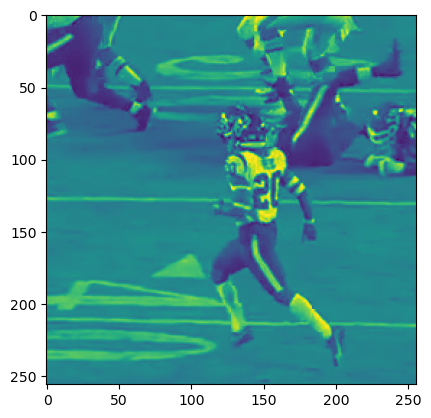

In [18]:
plt.imshow(img[0])
plt.show()

In [74]:
class Validator():
    def __init__(self, test_df, aug, criterion, transform, verbose=True):
        self.test_set = MyDataset(
            test_df, aug=aug, one_hot_transform=transform)
        self.verbose = verbose
        self.test_loader = DataLoader(
            self.test_set, batch_size=CFG['batch_size'], num_workers=CFG['num_workers'], shuffle=False, pin_memory=False, persistent_workers=bool(CFG['num_workers']))
        self.criterion = criterion

    def validate(self, model):
        y_hat = []
        y = []
        model.eval()
        with torch.no_grad():
            for batch in self.test_loader:
                imgs, features, labels = batch

                imgs = imgs.to(0, non_blocking=True)
                features = features.to(0, non_blocking=True)
                labels = labels.to(0, non_blocking=True)

                preds = model(imgs, features)
                print(preds.shape)
                y.append(labels.cpu().detach().numpy())
                y_hat.append(preds.cpu().detach().numpy())

            # print(y)
            # print(y_hat)
            for i in y:
                print(i.shape)
            y = np.hstack(y)
            y_hat = np.hstack(y_hat)
            # print(y.shape)
            # print(y_hat.shape)

            threshs = np.linspace(0.001, 0.999, 10000)

            mat_cors = []
            best = 0
            best_thresh = -1
            for thresh in threshs:
                _, val_mathew_corr,  _, = get_stats(
                    0.5, y, y_hat, cur_iter=f"Val", thresh=thresh)
                mat_cors.append(val_mathew_corr)
                if val_mathew_corr > best:
                    best = val_mathew_corr
                    best_thresh = thresh

        return mat_cors, threshs, best, best_thresh

In [23]:
class Validator():
    def __init__(self, df, aug, criterion, transform, verbose=True):
        self.test_set = MyDataset(
            df, aug=aug, train=False, one_hot_transform=transform)
        self.verbose = verbose
        self.counter = 0
        self.criterion = criterion

    def validate(self, model):
        y_hat = []
        y = []
        loss = 0
        # logger.debug("converting testloader to iter")
        # logger.debug("done converting testloader to iter")
        model.eval()
        with torch.no_grad():
            for iteration in tqdm(range(ceil(CFG['test_size']/CFG['batch_size']))):

                imgs, features, labels = self.test_set[iteration]
                imgs = imgs.to(0, non_blocking=True)
                features = features.to(0, non_blocking=True)
                labels = labels.to(0, non_blocking=True)

                preds = model(imgs, features)

                loss += self.criterion(preds,
                                       labels).cpu().detach().numpy().ravel()[0]
                y.append(labels.cpu().detach().numpy())
                y_hat.append(preds.cpu().detach().numpy())

            # logger.debug(f"Combined val labels:\n{y}")
            # logger.debug(f"Combined val preds:\n{y_hat}")
            y = np.hstack(y)
            y_hat = np.hstack(y_hat)
            # logger.debug(f"Combined val labels:\n{y}")
            # logger.debug(f"Combined val preds:\n{y_hat}")

            loss = loss/CFG['batch_size']

            threshs = np.linspace(0.001, 0.999, 10000)

            mat_cors = []
            best = 0
            best_thresh = -1
            for thresh in threshs:
                _, val_mathew_corr,  _, _, _ = get_stats(
                    loss, y, y_hat, cur_iter=f"Val", thresh=thresh)
                mat_cors.append(val_mathew_corr)
                if val_mathew_corr > best:
                    best = val_mathew_corr
                    best_thresh = thresh
            # tb.add_scalar("Val Loss", loss, iteration)
            # tb.add_scalar("Val  Accuracy", val_acc,
            #               iteration)
            # tb.add_scalar("Val Mathew Correlation",
            #               val_mathew_corr, iteration)
            # if self.verbose:
            #     logger.info(f"{stats}")

        return mat_cors, threshs, best, best_thresh
    
def get_stats(loss, y, y_pred, cur_iter='val', thresh=0.5):
    """
    Gets the stats for a particular batch
    """
    y_hat = (y_pred > thresh)*1.0
    mathew_corr = matthews_corrcoef(y, y_hat)
    acc = accuracy_score(y, y_hat)

    size = len(y_hat)
    classwise_mathew_corr = []
    classwise_acc = []
    for i in range(4):
        y_cl = y[i*(size//4):(i+1)*(size//4)]
        y_hat_cl = y_hat[i*(size//4):(i+1)*(size//4)]
        # logger.debug(f"{i}")
        # logger.debug(f"this is y_cl\n{y_cl}")
        # logger.debug(f"this is y_cl\n{y_hat_cl}")
        # logger.debug(f"cl mtcorr:{matthews_corrcoef(y_cl, y_hat_cl)}")
        # logger.debug(f"cl acc:{accuracy_score(y_cl, y_hat_cl)}")
        classwise_mathew_corr.append(matthews_corrcoef(y_cl, y_hat_cl))
        classwise_acc.append(accuracy_score(y_cl, y_hat_cl))

    stats = f'Iteration: {cur_iter} || Loss: {loss:.5f} || mat_corr: {mathew_corr:.5f} || acc: {acc:.5f}'
    stats += f""" 
|| G1_mat_corr: {classwise_mathew_corr[0]:.5f} || G0_mat_corr: {classwise_mathew_corr[1]:.5f} || P1_mat_corr: {classwise_mathew_corr[2]:.5f} || P0_mat_corr: {classwise_mathew_corr[3]:.5f}"""
    stats += f"""
||G1_acc: {classwise_acc[0]:.5f} || G0_acc: {classwise_acc[1]:.5f} || P1_acc: {classwise_acc[2]:.5f} || P0_acc: {classwise_acc[3]:.5f} EOL
    """

    return stats.replace("\n", ""),  mathew_corr, acc, classwise_mathew_corr, classwise_acc

In [75]:
def get_stats(loss, y, y_pred, cur_iter='val', thresh=0.5):
    """
    Gets the stats for a particular batch
    """
    y_hat = (y_pred > thresh)*1.0
    mathew_corr = matthews_corrcoef(y, y_hat)
    acc = accuracy_score(y, y_hat)

    stats = f'Iteration: {cur_iter} || Loss: {loss:.5f} || mat_corr: {mathew_corr:.5f} || acc: {acc:.5f} || EOL'
    return stats.replace("\n", ""),  mathew_corr, acc

In [76]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])


In [77]:
args = {
            "test_df": test_df,
            "aug": valid_aug,
            "criterion": nn.BCELoss(),
            "transform": one_hot,
            "verbose": True
        }

valer = Validator(**args)

In [78]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(
            'resnet50', pretrained=True, num_classes=250, in_chans=26)
        self.mlp = nn.Sequential(
            nn.Linear(77, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc = nn.Linear(64+250, 1)

    def forward(self, img, feature):
        img = self.backbone(img)
        feature = self.mlp(feature)
        y = torch.sigmoid(self.fc(torch.cat([img, feature], dim=1)))
        return y.flatten()

In [79]:
model = torch.load('./model_checkpoints/resnet50_fullforce_2023-02-12-01-02-29/best_model.pth')
model.eval()


Model(
  (backbone): ResNet(
    (conv1): Conv2d(26, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [80]:
mat_cors, threshs, best, best_thresh = valer.validate(model)

torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([40])
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(40,)


In [81]:
best, best_thresh

(0.9164693524934903, 0.36301080108010797)

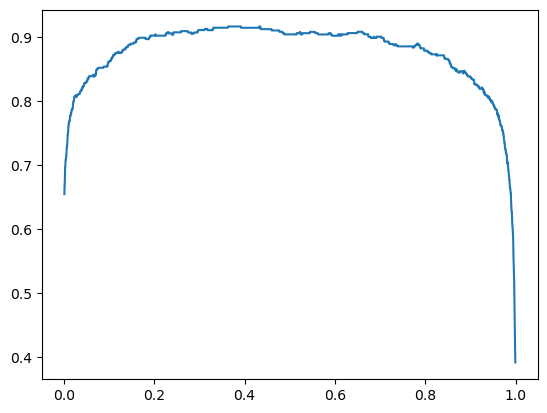

In [82]:
plt.plot(threshs, mat_cors)
plt.show()